## TD2. Vision Transformers
By Nicolas Dufour

In this TD, we will implement the Transformers architecture. Transformers has been a key architecture in deep learning for the past 5 years.

It has first began with NLP, then came audio and finally, since 2020, computer vision.
We will implement every block that makes a transformer from scratch and we will try to create a deep understanding of what is happening.
Here is a figure for the transformer architecture:


<img src="https://www.researchgate.net/profile/Miruna-Gheata/publication/355339249/figure/fig1/AS:1079476452622337@1634378650979/Encoder-decoder-architecture-of-the-Transformer-developed-by-Vaswani-et-al-28.ppm" width=768>

## Instructions
In `pytorch` you must avoid using for loops at all cost. It's almost always possible to find a vectorized version of the operation you want to implement.

**In this TP, the only for-loop you can do is the training loop.**

In [1]:
!pip install einops
!pip install timm

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
import math
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from einops import rearrange, repeat
from PIL import Image
from torchvision import transforms
import requests

torch.manual_seed(0)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Part 1. The attention mechanism

### Implementing the scaled dot-product attention mechanism

The transformer architecture is built around one key block: The attention.
The idea behind attention is the following. Imagine you want to retrieve information from a dictionary. The dictionnary is indexed by keys which maps to a particular value. Now, you have a query which will be matched against the keys of the dict and if you have a match, you will retrieve the associated value.
Attention is very similar to this simple retrieval example. Now, with real data, we don't have this structure, we however are going to learn to create it.

We have 2 sets of vectors (also named tokens). One is $X_{to}$ which is the destination set. We want to be able to map this set of tokens to queries. We achieve this by doing a linear projection of $X_{to}$ to obatain:  $Q = W_QX_{to}$

The other set is $X_{from}$ the set from which we want to retrieve information. We will need to extract both keys and values from this set. We therefore do 2 linear projections of $X_{from}$ to obtain:  $K = W_KX_{from}$ and $V = W_VX_{from}$.

Now, contrary to the dictionnary where queries and values are exact matchs, we don't have this here. Therefore, we will perform a softer match by computing the similarity matrix between $Q$ and $K$. Then for each $Q$, we want to output the values that have the higher similarity. We therefore output the weighted sum of the values, weighted by the softmax of the similarity (also called the attention matrix).

Finally, the attention operation is given by the cross attention:

$$
A(Q,K,V) = \text{SoftMax}(\frac{QK^T}{\sqrt{d_k}})V
$$

We divide the similarity by $\sqrt{d_k}$ for stability reason to avoid the similarity to explode with big vectors which would lead to very sharp attention coeficients.

#### Question 1.
Implement the attention operation, use  `torch.einsum` to easily compute the similarity matrix.

In [3]:
class Attention(nn.Module):
    def __init__(self, x_to_dim, x_from_dim, hidden_dim,):
        super(Attention, self).__init__()
        self.W_q = nn.Linear(x_to_dim, hidden_dim)
        self.W_k = nn.Linear(x_from_dim, hidden_dim)
        self.W_v = nn.Linear(x_from_dim, hidden_dim)
        self.d_k = hidden_dim

    def forward(self, x_to, x_from):
        Q = self.W_q(x_to)
        K = self.W_k(x_from)
        V = self.W_v(x_from)
        soft_max = F.Softmax(torch.einsum("bik,bjk->bij", Q, K) / torch.sqrt(self.d_k), dim=-1)
        return torch.matmul(soft_max, V)

### Multi-head attention

We improve the above attention implementation by introducing multi-head attention. The idea here is that we compute the attention on subspaces of the $Q,K,V$ triplets.
We split each vector in $n$ subsets and compute the attention for each subset. At the end, we concatenate every attention output and project it with an output projection.

#### Question 2.
Implement Multihead attention.

In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self, x_to_dim, x_from_dim, hidden_dim, n_heads):
        super(MultiHeadAttention, self).__init__()

        self.head_dim = x_to_dim//n_heads
        self.n_heads = n_heads
        self.d_k = hidden_dim

        self.W_q = nn.Linear(x_to_dim, hidden_dim)
        self.W_k = nn.Linear(x_from_dim, hidden_dim)
        self.W_v = nn.Linear(x_from_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, x_to, x_from):
        batch_size = x_to.size(0)

        Q = self.W_q(x_to)
        K = self.W_k(x_from)
        V = self.W_v(x_from)

        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)

        attention = F.Softmax(torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(self.d_k), dim=-1)
        head_output = torch.matmul(attention, V)

        concat_output = head_output.transpose(1, 2).contiguous().view(batch_size, -1, self.n_heads * self.head_dim)
        return self.output_layer(concat_output)


MultiheadAttention is the attention that is used in transformers in pratice. It is used in 2 flavors:
- Self Attention: When $X_{to}$ attends itself ($X_{to}=X_{from}$)
- Cross Attention. $X_{to}\neq X_{from}$


#### Question 3.
Implement MultiHead Self Attention and MultiHeadCrossAttention

In [41]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, x_dim, hidden_dim, n_heads):
        super(MultiHeadSelfAttention, self).__init__()

        self.head_dim = hidden_dim // n_heads
        self.n_heads = n_heads
        self.d_k = self.head_dim

        self.W_q = nn.Linear(x_dim, hidden_dim)
        self.W_k = nn.Linear(x_dim, hidden_dim)
        self.W_v = nn.Linear(x_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, x_dim)

    def forward(self, x):
        batch_size = x.size(0)

        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)

        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)

        attention = F.softmax(torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_k), dim=-1)
        head_output = torch.matmul(attention, V)

        concat_output = head_output.transpose(1, 2).contiguous().view(batch_size, -1, self.n_heads * self.head_dim)
        return self.output_layer(concat_output)

class MultiHeadCrossAttention(MultiHeadAttention):
    def __init__(self, x_to_dim, x_from_dim, hidden_dim, n_heads):
        super(MultiHeadCrossAttention, self).__init__()

        self.head_dim = x_to_dim//n_heads
        self.n_heads = n_heads
        self.d_k = hidden_dim

        self.W_q = nn.Linear(x_to_dim, hidden_dim)
        self.W_k = nn.Linear(x_from_dim, hidden_dim)
        self.W_v = nn.Linear(x_from_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, x_to, x_from):
        batch_size = x_to.size(0)

        Q = self.W_q(x_to)
        K = self.W_k(x_from)
        V = self.W_v(x_from)

        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)

        attention = F.Softmax(torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(self.d_k), dim=-1)
        head_output = torch.matmul(attention, V)

        concat_output = head_output.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.head_dim)
        return self.output_layer(concat_output)

### LayerNorm
Another key component of the transformer is the LayerNorm. As we have previously seen, normalizing the output of a deep learning layer helps a lot with convergence and stability.
Until Transformers, the most used normalization is BatchNorm. We normalize the data among the batch dimension. However, this has a few problems.
- The normalization depend on the other samples in the batch
- When using multiple GPUs, BatchNorm needs to synchronize the batch statistic across GPUs, which locks the forward process and slow down training.

The last element is the most important one. Transformers, aims to be a easy to parralilize architecture and can't afford to use batchnorm.

Instead, Transformers uses Layer Norm. LayerNorm is sample dependent, which removes the synchronization issue. We normalize over the channel dimension instead of the batch dimension.

<img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-05-19_at_4.24.42_PM.png">

To account for the loss of capacity, we map the output by a linear transformation with a learned bias and scale.

#### Question 4.
Implement the LayerNorm

In [6]:
class LayerNorm(nn.Module):
    def __init__(self, dim):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(dim)) # scale
        self.beta = nn.Parameter(torch.zeros(dim)) # bias

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        variance = x.var(dim=-1, keepdim=True, unbiased=False)
        x_normalized = (x - mean) / torch.sqrt(variance)
        return self.gamma * x_normalized + self.beta



### Feed Feedward Network

Finally, the last block is a feed-forward network with one hidden layer. This layer has usually a size of $2 * input\_dim$. This is followed by a dropout layer and an activation function. Here, we will use leaky relu, with a leak parameter of 0.1.

#### Question 5.
Implement the FFN layer

In [14]:
class FFN(nn.Sequential):
    def __init__(self, hidden_dim, dropout_rate=0.1, expansion_factor=2):
        super(FFN, self).__init__()
        self.ff1 = nn.Linear(hidden_dim, expansion_factor*hidden_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.ff1(x)
        x = F.leaky_relu(self.dropout(x), negative_slope=0.1)
        return x

### The Transformer block

The last thing that we are missing are the skip connection. Like in ResNet, the transformer architecture implements the skip-connection. This allow for a better gradient flow avoiding vanishing gradient.
There is a skip connection after the attention and the feed forward network

#### Question 6.
Given at the transformer figure at the top, implement the Transformer Encoder Block

In [45]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self ,data_dim, hidden_dim, n_heads, dropout_rate=0.1):
        super(TransformerEncoderBlock, self).__init__()

        self.mhsa = MultiHeadSelfAttention(data_dim, hidden_dim, n_heads)
        self.norm1 = LayerNorm(data_dim)
        self.norm2 = LayerNorm(data_dim)
        self.ffn = FFN(data_dim, dropout_rate=dropout_rate)
        self.ffn_output_proj = nn.Linear(hidden_dim * 2, data_dim)

    def forward(self, x):
        x = self.norm1(x + self.mhsa(x))
        x = self.norm2(x + self.ffn_output_proj(self.ffn(x)))
        return x


### Positional embedding
The transformers architecture is permutation independent. That means that for every token, we can swap 2 tokens and have the exact same result. However, the position of the token can be a very important information to consider. Imagine in an image. If a pixel is nearby another pixel, we want the transformer to be able to capture such information. Which is not the case for now.
That's why we introduce positional encodings. For each token, add the positional encoding to the original token:

$$
X_i = X_i + PE(i)
$$

with X_i the token at the i dimension.

The most used positional encodings are sinusoidal encodings. They are defined as follow:

$$
PE(i, 2j) = sin(i / 10000^{\frac{2j}{d}}) \\
PE(i, 2j + 1) = cos(i / 10000^{\frac{2j}{d}})
$$


Where $d$ the dimension of the tokens, $i$, the i-th token in the sequence and $2j$ (resp $2j + 1$), the index of the dimension of the vector.
The idea here is that we add a sinusoidal that encode the position in a multidimensional array.

Another common positional encodings is the learned positional encoding. Simply, we let the network learn a set of tensor $PE$ that match the sequence length and dimension of the tokens.

#### Question 7.

Implement both Sinusoidal and Learned positional embeddings

In [9]:
class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, hidden_dim):
        super(SinusoidalPositionalEncoding, self).__init__()
        self.hidden_dim = hidden_dim



    def forward(self, x):
        seq_len = x.size(1)
        pos = torch.arange(seq_len).unsqueeze(1)
        pos_embedding = torch.zeros(seq_len, self.hidden_dim)
        pos_embedding[:, 0::2] = torch.sin(pos / 10000 ** (torch.arange(0, self.hidden_dim, 2) / self.hidden_dim))
        pos_embedding[:, 1::2] = torch.cos(pos / 10000 ** (torch.arange(0, self.hidden_dim, 2) / self.hidden_dim))
        return x + pos_embedding

class LearnedPositionalEncoding(nn.Module):
    def __init__(self, hidden_dim, max_len):
        super(LearnedPositionalEncoding, self).__init__()
        self.positional_embedding = nn.Embedding(max_len, hidden_dim)


    def forward(self, x):
        seq_len = x.size(1)
        pos = torch.arange(seq_len).unsqueeze(0)
        pos_embedding = self.positional_embedding(pos)
        return x + pos_embedding

### The transformer encoder
Now you have everything you need to implement the transformer . You add positional encoding to the tokens and then stack N transformer encoder layers

#### Question 8.
Implement the transformer encoder with n_layers and the ability to choose both positional embeddings.

Tip: Look into `ModuleList`

In [10]:
class TransformerEncoder(nn.Module):
    def __init__(self, data_dim,  hidden_dim, n_heads, n_layers, dropout_rate=0.1, positional_encoding="sinusoidal", max_len=1000):
        super(TransformerEncoder, self).__init__()

        self.layers = nn.ModuleList([TransformerEncoderBlock(data_dim, hidden_dim, n_heads, dropout_rate) for _ in range(n_layers)])
        self.positional_encoding = SinusoidalPositionalEncoding(hidden_dim) if positional_encoding == "sinusoidal" else LearnedPositionalEncoding(hidden_dim, max_len)

    def forward(self, x):
        x = self.positional_encoding(x)
        for layer in self.layers:
            x = layer(x)
        return x

# Part 2. Classical Architectures: ViT & CCT

## The Vision Transformer
The above architecture was introduced in 2017 to process sequences of text tokens. However, it could be useful to be able to leverage this architecture for computer vision. On the contrary of convolutional neural network, the transformer has the advantage to introduce less inductive bias.

This could be interesting to leverage to improve vision systems. If we learn the biases from the data, we can hope to have better performances. We however need compute and a lot of data to do this.

To apply the transformer to images, one key question remains to be answered: How do we transform an image to tokens? The approach introduce in Vision Transformers is to cut the image into patches that are then transformed into a token trhought a linear projection.

We also add an extra token, known as the classification token, that will be the token which will be use to predict upon. After going through the N transformer layers, this is the token that goes throught a multi layer perceptron.


<img src= "https://1.bp.blogspot.com/-_mnVfmzvJWc/X8gMzhZ7SkI/AAAAAAAAG24/8gW2AHEoqUQrBwOqjhYB37A7OOjNyKuNgCLcBGAsYHQ/s1600/image1.gif" width="512">


#### Question 9

Implement the vision transformer

Hint: Use Conv2D with the right kernel size and stride to do the linear projection of non-overlapping patches.

In [11]:
class ViT(nn.Module):
    def __init__(self, patch_size, hidden_dim, n_heads, n_layers, n_classes, dropout_rate=0.1, positional_encoding="sinusoidal", max_len=1000):
        super(ViT, self).__init__()
        self.patch_size = patch_size
        self.hidden_dim = hidden_dim
        self.n_heads = n_heads
        self.n_layers = n_layers
        self.n_classes = n_classes
        self.dropout_rate = dropout_rate
        self.positional_encoding = positional_encoding
        self.max_len = max_len

        self.conv_proj = nn.Conv2d(in_channels=3, out_channels=hidden_dim, kernel_size=patch_size, stride=patch_size)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, hidden_dim))
        self.dropout = nn.Dropout(dropout_rate)

        self.transformer = TransformerEncoder(hidden_dim, hidden_dim, n_heads, n_layers, dropout_rate, positional_encoding, max_len)
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, n_classes)
        )

    def forward(self, x):
        batch_size = x.size(0)
        x = self.conv_proj(x)  # Shape: [batch_size, hidden_dim, H/patch_size, W/patch_size]
        x = x.flatten(2).transpose(1, 2)  # Shape: [batch_size, num_patches, hidden_dim]

        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # Shape: [batch_size, 1, hidden_dim]
        x = torch.cat((cls_tokens, x), dim=1)  # Shape: [batch_size, num_patches + 1, hidden_dim]

        x = self.dropout(x)
        x = self.transformer(x)  # Shape: [batch_size, num_patches + 1, hidden_dim]

        cls_token_final = x[:, 0]  # Shape: [batch_size, hidden_dim]
        out = self.mlp_head(cls_token_final)  # Shape: [batch_size, n_classes]
        return out

#### Question 10.
Train a ViT on CIFAR10 for 100 epochs (for compute reason you can use only 20 epochs) and log both train and test loss and accuracy.
We provide a data augmentation strategy called auto augment to avoid overfitting on the training data.
Hparameters are to be choosen to your discretion.


Tips for Hparams:
- Don't use a transformer hidden dim too big (<256)
- Use a small patch size
- Use AdamW with some weight decay to avoid overfitting
- Use between 2 and 6 transformer layers.
- Use between 2 and 4 transformer heads

In [12]:
batch_size = 128
train_set = CIFAR10(root='./data', train=True, download=True, transform=transforms.Compose([
    transforms.autoaugment.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
]))

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)

test_set = CIFAR10(root='./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
]))

test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)

Files already downloaded and verified


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Files already downloaded and verified


In [47]:
# Define the model
model = ViT(
    patch_size=4,
    hidden_dim=128,
    n_heads=4,
    n_layers=4,
    n_classes=10,
    dropout_rate=0.1,
    positional_encoding="sinusoidal",
    max_len=1000
).to(device)

# Define the optimizer and loss function
optimizer = AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Testing function
def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Training and testing loop
num_epochs = 5
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = test(model, test_loader, criterion, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

100%|██████████| 79/79 [00:38<00:00,  2.07it/s]


Epoch 1/5, Train Loss: 1.9390, Train Acc: 0.2917, Test Loss: 1.5159, Test Acc: 0.4616


100%|██████████| 79/79 [00:37<00:00,  2.09it/s]


Epoch 2/5, Train Loss: 1.6215, Train Acc: 0.4172, Test Loss: 1.3336, Test Acc: 0.5229


100%|██████████| 79/79 [00:37<00:00,  2.08it/s]


Epoch 3/5, Train Loss: 1.5006, Train Acc: 0.4622, Test Loss: 1.2360, Test Acc: 0.5540


100%|██████████| 79/79 [00:38<00:00,  2.06it/s]


Epoch 4/5, Train Loss: 1.4202, Train Acc: 0.4885, Test Loss: 1.1743, Test Acc: 0.5727


100%|██████████| 79/79 [00:37<00:00,  2.12it/s]

Epoch 5/5, Train Loss: 1.3713, Train Acc: 0.5119, Test Loss: 1.1163, Test Acc: 0.6006


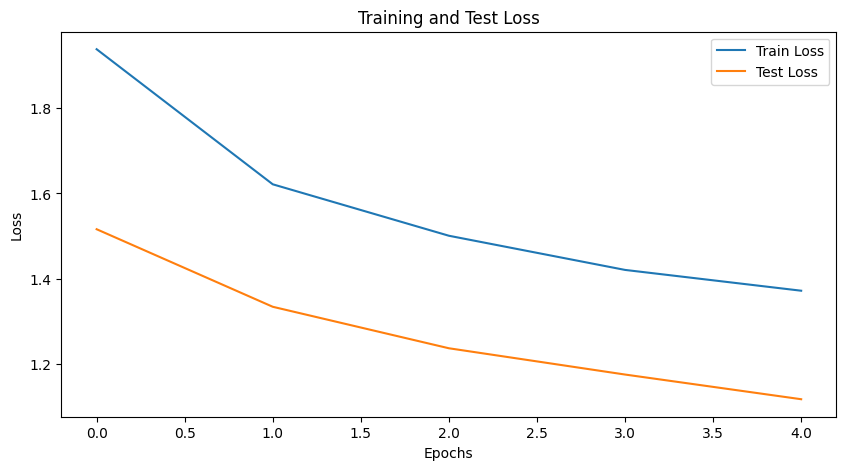

In [48]:
# Plot the training and test loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

## Compact Convolutional Transformer
The previous network requires a lot of compute and data to be trained. As we mentionned before, the transformer removes the inductive bias of convnets which requires more data to be trained.

To bypass this, let's try out another architecture. We will try an hybrid architecture that preserves the inductive biases of convolution but manages to use the transformer to add global learning.

The first change is the tokenizer. We replace it with a ConvNet. Each convnet layer has a convolution, ReLU and maxpooling.
The second change is to actually remove the classfication token and classify on top of a pooling of all tokens. The pooling is done with an attention like mechanism:
- For each sample, we predict a scalar, that we compute the softmax over all the sample tokens.
- We then do an weighted average pool by this softmax values over the tokens. The weight is given by the previous step

More details see: https://arxiv.org/abs/2104.05704

<img src= https://miro.medium.com/v2/resize:fit:720/format:webp/1*8diH01Fl7MhHRemLy9hUHw.png width=512>

#### Question 11.
Implement the Convolutional based tokenizer and the SeqPool operationm

In [ ]:
class ConvPatchEmbedding(nn.Module):
    def __init__(self, n_layers, kernel_size, hidden_dim):
        # To complete
        pass

    def forward(self, x):
        # x = [batch size, 3, image height, image width]
        # To complete
        pass

class SeqPool(nn.Module):
    def __init__(self, hidden_dim):
        # To complete
        pass

    def forward(self, x):
        # x = [batch size, seq len, hidden dim]
        # To complete
        pass

#### Question 12.

Implement the Compact Convolutional Transformer.

In [ ]:
class CCT(nn.Module):
    def __init__(self, n_conv_layers, kernel_size,  n_transformer_layers, hidden_dim, n_heads, n_classes, dropout_rate=0.1):
        # To complete
        pass

    def forward(self, x):
        # x = [batch size, 3, image height, image width]
        # To complete
        pass

#### Question 13.
Train the CCT on CIFAR-10 for 100 epochs (for compute reason you can use only 20 epochs) and log both train and test loss and accuracy. You should obtain at least 75+% test accuracy, and observe a improvement compared to the previous ViT (Possible to get 90%+).
We provide a data augmentation strategy called auto augment to avoid overfitting on the training data.
Hparameters are to be choosen to your discretion.

Tips for Hparams:
- Don't use too big of a transformer hidden dim (<256)
- For the convnet, aim to have between 32 and 128 output tokens.
- Use AdamW with some weight decay to avoid overfitting
- Use between 2 and 6 transformer layers.
- Use between 2 and 4 transformer heads

Training takes around 30min (depending of hparams).

In [ ]:
batch_size = 128
train_set = CIFAR10(root='./data', train=True, download=True, transform=transforms.Compose([
    transforms.autoaugment.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
]))

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)

test_set = CIFAR10(root='./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
]))

test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)


In [ ]:
# To complete: train the model, (don't forget to test it)

In [ ]:
# Plot the training and test loss